In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from astropy import units as u
from astropy.constants import c
import datetime

In [14]:
pathtemplate = "data" #put the filepath to the data here

In [15]:
#class to hold solar transit data - initially implemented by Joe and edited by me
class Transit:
    def __init__(self, date, dec, horn, noon):
        self.date = date #date is the filename of the solar scan data
        self.dec = dec #dec at solar noon (get from noaa solar calculator)
        self.horn = horn #E or W
        self.noon = noon #solar noon time (get from noaa solar calculator)
    def get_data(self):
        folder = os.path.join(pathtemplate, f"{self.date}")
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a2p1, a1p2, a1p1, a2p2))

        #a1p1, a2p2 = WEST, a1p2, a2p1 = EAST

        return datetimes, power_array

In [16]:
#example using the solar scan from 10/05/24 (this will need to have been downloaded from the google drive)
transit = Transit('10th May 2024', 17.82, 'W', datetime.datetime(2024, 5, 10, 12, 5, 38))

In [17]:
#equation of gaussian with baseline for fitting
def gaussian_with_baseline(x, a, b, c, d, m):
    return a*np.exp(-((x-b)**2)/(2*(c/(2*np.sqrt(2*np.log(2))))**2)) + m*x + d

#function to fit a gaussian with baseline to data
def gaussian_with_baseline_fitting(x, y):
    p0 = np.array([np.max(y), x[np.argmax(y)], 23, 0, 0]) #change initial guess for parameters here if fitting times out
    popt, pcov = optimize.curve_fit(gaussian_with_baseline, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

#function for fitting a line to data
def line_fitting(x_data, y_data, y_uncertainties):

    weights = 1. / y_uncertainties**2
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights)**2)

    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights) - np.sum(x_data * weights) * np.sum(y_data * weights)) / repeated_term)
    slope_uncertainty = np.sqrt(np.sum(weights) / repeated_term)

    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights) * np.sum(x_data * y_data * weights)) / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term)

    return (np.array([slope, offset]), np.array([slope_uncertainty, offset_uncertainty]))

#function to find the nearest value in an array to a given value, used to rebin LAB data for comparison with L-BASS hydrogen profiles
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [18]:
#function to find total power beam size and how beam size changes with frequency for a solar scan
#transit is the Transit object
#cw is a boolean, 1 if the scan needs the CW signal removed, 0 if not
#start and end are the indices of the data to use in the scan (allows for trimming the beginning and end of scans), use 0 and -1 to use all data
def solar_scan(transit, cw, start, end):
    
    #selecting which arrays of data to look at depending on the horn
    if transit.horn == 'E':
        int1 = 0
        int2 = 1
        int3 = 2
        int4 = 3
    elif transit.horn == 'W':
        int1 = 2
        int2 = 3
        int3 = 0
        int4 = 1

    #read out data from Transit object
    t, pwr = transit.get_data()

    #removing CW signal if necessary
    if cw == 1:
        cw_chan1 = np.argmax(pwr[int1][int(len(pwr[int1])/2), 112:567])
        cw_chan2 = np.argmax(pwr[int3][int(len(pwr[int3])/2), 112:567])
        print(cw_chan1, cw_chan2)
        for i in range(0,len(pwr[int1])):
            for j in range(cw_chan1 - 2 + 112, cw_chan1 + 2 + 112):
                pwr[int1][i, j] = np.nan
                pwr[int2][i, j] = np.nan
            for j in range(cw_chan2 - 2 + 112, cw_chan2 + 2 + 112):
                pwr[int1][i, j] = np.nan
                pwr[int2][i, j] = np.nan
    
    #averaging across each frequency channel
    tot_pwr = np.nanmean(pwr[int1,start:end,112:567], axis=1) *10.65 #10.65 is the conversion factor from au to Kelvin
    angle = np.cos(transit.dec*np.pi/180)*np.linspace(1,len(tot_pwr),len(tot_pwr)) * 360/(60*24) #angle moved through by the Sun in degrees, accounting for solar declination

    #fitting a gaussian with baseline to the data and calculting the FWHM
    popt, pcov = gaussian_with_baseline_fitting(angle, tot_pwr)
    fwhm = popt[2]
    fwhm_error = np.sqrt(np.diag(pcov)[2])

    #plotting the data and the fit
    plt.figure(figsize=(10, 5))
    plt.plot(angle, tot_pwr, "k.")
    plt.plot(np.linspace(np.min(angle), np.max(angle), 1000), gaussian_with_baseline(np.linspace(np.min(angle), np.max(angle), 1000), *popt), "r")
    plt.xlabel('Angle moved through by Sun [degrees]')
    plt.ylabel('Brightness Temperature [K]')
    plt.grid(True)
    plt.title("Solar Drift Scan {0} - {1}".format(transit.date, transit.horn))
    plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
    plt.show()

    #fitting a gaussian and calculating the FWHM for each frequency channel
    fwhm_freq = np.empty((457,2))
    fwhm_freq_error = np.empty((457,2))
    freq = np.linspace(1400, 1425, 457)

    for i in range(112, 569):
        chnl_pwr = pwr[int1][start:end,i]
        trimmed_pwr = np.nan_to_num(chnl_pwr, nan=0.0)
        popt, pcov = gaussian_with_baseline_fitting(angle, trimmed_pwr)
        fwhm_freq[i-112][0] = popt[2]
        fwhm_freq_error[i-112][0] = np.sqrt(np.diag(pcov)[2])

    for i in range(112, 569):
        chnl_pwr = pwr[int2][start:end,i]
        trimmed_pwr = np.nan_to_num(chnl_pwr, nan=0.0)
        popt, pcov = gaussian_with_baseline_fitting(angle, trimmed_pwr)
        fwhm_freq[i-112][1] = popt[2]
        fwhm_freq_error[i-112][1] = np.sqrt(np.diag(pcov)[2])

    #fitting a line to find the linear relationship between beam size and frequency
    line_fit_0, line_errors_0 = line_fitting(freq, fwhm_freq[:,0], fwhm_freq_error[:,0])
    line_fit_1, line_errors_1 = line_fitting(freq, fwhm_freq[:,1], fwhm_freq_error[:,1])

    #plotting the beam size for each frequency channel and the linear fits
    plt.figure(figsize=(20, 10))
    plt.errorbar(freq, fwhm_freq[:,0], fwhm_freq_error[:,0], fmt="ko", ecolor = "r", alpha=0.7, label = '0 phase')
    plt.errorbar(freq, fwhm_freq[:,1], fwhm_freq_error[:,1], fmt="bo", ecolor = "g", alpha=0.7, label = 'Pi phase')
    plt.plot(freq, line_fit_0[0]*freq+line_fit_0[1],'--', color="k")
    plt.plot(freq, line_fit_1[0]*freq+line_fit_1[1],'--', color='b')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Beam Width [degrees]')
    plt.grid(True)
    plt.title("Solar Drift Scan {0} - {1}".format(transit.date, transit.horn))
    plt.legend()
    plt.show()

252 242


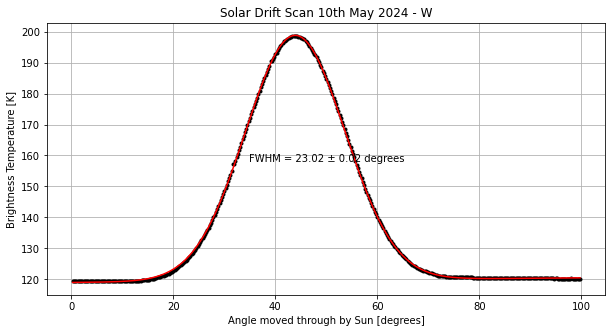

c:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


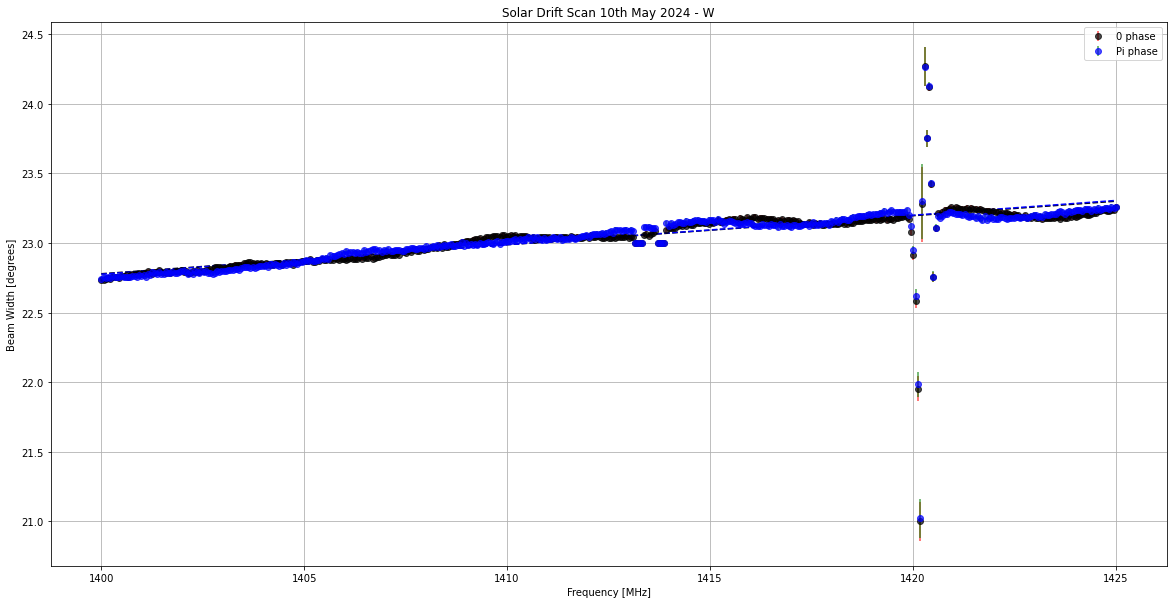

In [19]:
#example of running the solar scan function on the 10/05/24 solar scan
solar_scan(transit, 1, 0, -1)

In [30]:
#function to compare an L-BASS hydrogen profile with data from the LAB survey with a given LSR correction
#transit is the Transit object containing the hydrogen profile
#time is the time of the hydrogen profile from the start of the transit in minutes
#lab is the LAB data for the desired hydrogen profile (downloaded from https://www.astro.uni-bonn.de/hisurvey/euhou/LABprofile/index.php)
#lsr_corr is the LSR correction to apply to the velocity of the hydrogen profile in km/s
#start and end are the frequency channels to interpolate over for bandpass subtraction (ie the hydrogen profile lies between these channels)
def profile(transit, time, lab, lsr_corr, start, end):

    #selecting which arrays of data to look at depending on the horn
    if transit.horn == 'E':
        int1 = 0
        int2 = 1
        int3 = 2
        int4 = 3
    elif transit.horn == 'W':
        int1 = 2
        int2 = 3
        int3 = 0
        int4 = 1

    t, pwr = transit.get_data()

    pwr_trim = pwr[:,time-1:time+1,:] * 10.65 #selecting the data for one minute either side of the hydrogen profile
    pwr_trim[int1, :,np.argmax(pwr_trim[int1,:,:])-3:np.argmax(pwr_trim[int1,:,:])+3] = 1 #removing the CW signal so that the bandpass plot is readable
    
    freq = np.linspace(1400, 1425, 457) #generating frequency array

    #interpolating over the hydrogen signal (across channels start-end) and subtracting the bandpass
    profile_bandpass = np.empty(718)
    for i in range(0,718):
        profile_bandpass[i] = np.sum(pwr_trim[int1][:,i])
    bandpass = np.concatenate((profile_bandpass[:start], np.linspace(0,0,end-start), profile_bandpass[end:]))
    zero_indices = np.where(bandpass == 0)[0]
    non_zero_indices = np.where(bandpass != 0)[0]
    bandpass[zero_indices] = np.interp(zero_indices, non_zero_indices, bandpass[non_zero_indices])
    profile = (profile_bandpass-bandpass)[112:569]

    plt.figure(figsize=(10, 5))
    plt.plot(freq, profile_bandpass[112:569], marker=".", color='b', label="L-BASS Signal")
    plt.plot(freq, bandpass[112:569], color='r', label="Baseline")
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Brightness Temperature [K]')
    plt.grid(True)
    plt.legend()
    plt.show()

    hydrogen_line = 1420.405751786 #hydrogen line frequency in MHz
    vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + lsr_corr*(u.km/u.s) #converting frequency to velocity with LSR correction
    
    #rebinning LAB data to match L-BASS data
    lab_vel = lab[:,0]
    lab_pwr = lab[:,1] / np.max(lab[:,1])
    lab_rebinned = np.empty(len(vel))
    width = ((vel[1]-vel[0])/2).value
    for i in range(len(vel)):
        rhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value-width))[0])
        lhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value+width))[0])
        lab_rebinned[i] = np.sum(lab_pwr[lhs-1:rhs])

    #plotting the L-BASS and LAB data (step plot)
    plt.figure(figsize=(20, 10))
    plt.step(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.step(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.step(vel,profile/np.max(profile), marker=".", color='b', label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    #plotting the L-BASS and LAB data (line plot)
    plt.figure(figsize=(20, 10))
    plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.plot(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.plot(vel,profile/np.max(profile), color='b', marker=".", label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    #calculating and plotting the residuals between the L-BASS and LAB data
    residuals = -(profile/np.max(profile)-lab_rebinned/np.max(lab_rebinned))
    plt.figure(figsize=(20, 10))
    plt.plot(vel, residuals, marker=".", color='g', label="Residuals")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile Residuals")
    plt.xlim(-150,50)
    plt.show()

    #calculating the integrated area under the LAB and L-BASS profiles
    lab_int = np.abs(np.sum(lab_rebinned/np.max(lab_rebinned) * np.diff(vel)[0]))
    lb_int = np.abs(np.sum(profile/np.max(profile) * np.diff(vel)[0]))

    print("Area under LAB profile: ", "{0:.3}".format(lab_int.value))
    print("Area under L-BASS profile: ", "{0:.3}".format(lb_int.value))
    print("Difference as a % of L-BASS profile: ", "{0:.3}".format(100*np.abs((lb_int-lab_int)/lb_int).value), "%")

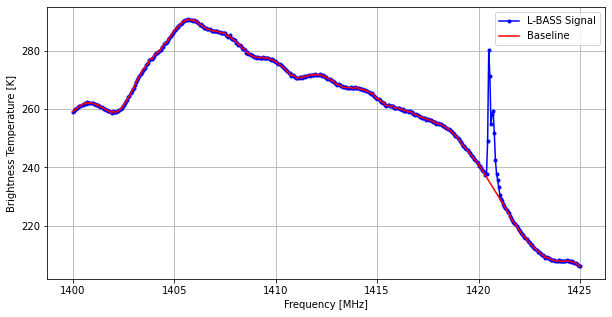

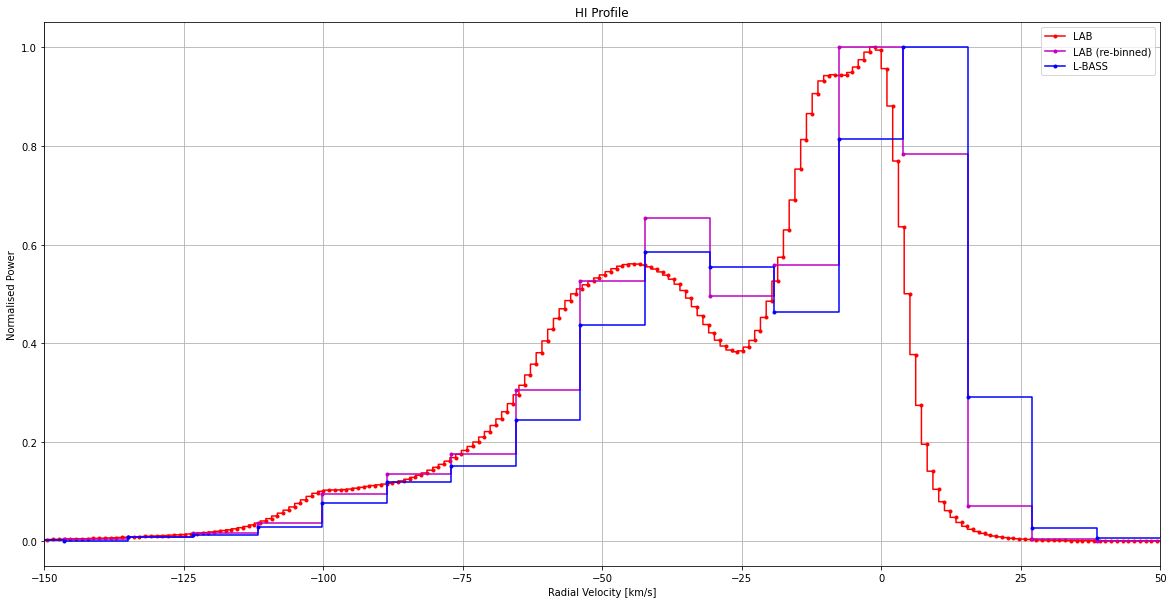

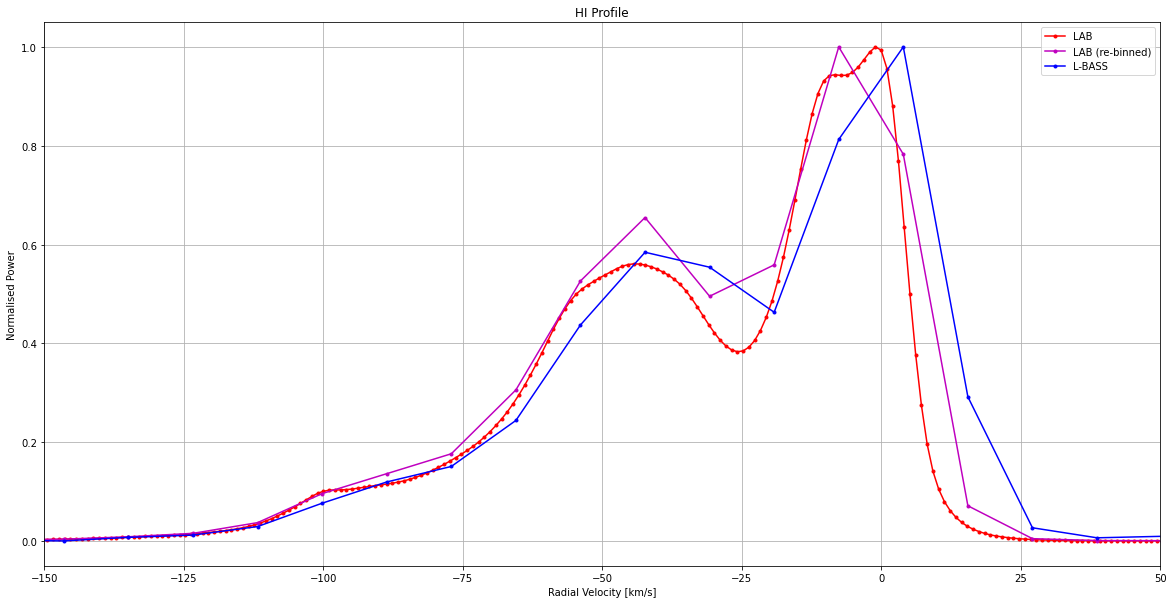

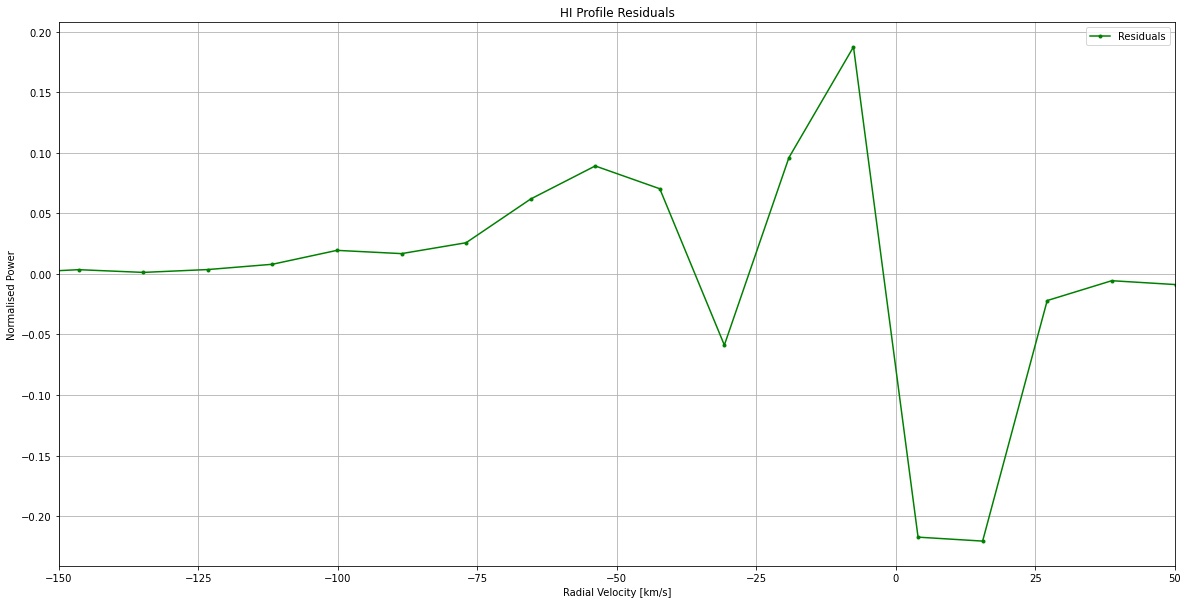

Area under LAB profile:  56.7
Area under L-BASS profile:  56.0
Difference as a % of L-BASS profile:  1.29 %.


In [31]:
#example of running the profile function on the 31/07/24 observation of S7
s7_transit = Transit('31st July 2024 - S7', 60.32, 'E', datetime.datetime(2024, 7, 31, 5, 36, 14))
s7_lab = np.genfromtxt("data/hydrogen profiles/s7_lab.txt", skip_header=4)
profile(s7_transit, 20, s7_lab, 24.78, 480, 501)

In [32]:
#function to compare an L-BASS hydrogen profile with data from the LAB survey, finding the best-fit "empirical" LSR correction
#transit is the Transit object containing the hydrogen profile
#time is the time of the hydrogen profile from the start of the transit in minutes
#lab is the LAB data for the desired hydrogen profile (downloaded from https://www.astro.uni-bonn.de/hisurvey/euhou/LABprofile/index.php)
#start and end are the frequency channels to interpolate over for bandpass subtraction (ie the hydrogen profile lies between these channels)
def profile_empirical_vel(transit, time, lab, start, end):

    #selecting which arrays of data to look at depending on the horn
    if transit.horn == 'E':
        int1 = 0
        int2 = 1
        int3 = 2
        int4 = 3
    elif transit.horn == 'W':
        int1 = 2
        int2 = 3
        int3 = 0
        int4 = 1
    
    t, pwr = transit.get_data()

    pwr_trim = pwr[:,time-1:time+1,:] * 10.65 #selecting the data for one minute either side of the hydrogen profile
    pwr_trim[int1, :,np.argmax(pwr_trim[int1,:,:])-3:np.argmax(pwr_trim[int1,:,:])+3] = 1 #removing the CW signal so that the bandpass plot is readable

    freq = np.linspace(1400, 1425, 457) #generating frequency array

    #interpolating over the hydrogen signal (across channels start-end) and subtracting the bandpass
    profile_bandpass = np.empty(718)
    for i in range(0,718):
        profile_bandpass[i] = np.sum(pwr_trim[int1][:,i])
    bandpass = np.concatenate((profile_bandpass[:start], np.linspace(0,0,end-start), profile_bandpass[end:]))
    zero_indices = np.where(bandpass == 0)[0]
    non_zero_indices = np.where(bandpass != 0)[0]
    bandpass[zero_indices] = np.interp(zero_indices, non_zero_indices, bandpass[non_zero_indices])
    profile = (profile_bandpass-bandpass)[112:569]

    plt.figure(figsize=(10, 5))
    plt.plot(freq, profile_bandpass[112:569], marker=".", color='b', label="L-BASS Signal")
    plt.plot(freq, bandpass[112:569], color='r', label="Baseline")
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Brightness Temperature [K]')
    plt.grid(True)
    plt.legend()
    plt.show()

    hydrogen_line = 1420.405751786 #hydrogen line frequency in MHz
    lsr_corr = np.linspace(-25,25,10000)*u.km/u.s #LSR correction array to search over
    residuals = np.empty(10000) #array to store residuals

    #rebin LAB data to match L-BASS data and search for the best-fit LSR correction that minimises the residuals
    lab_vel = lab[:,0]
    lab_pwr = lab[:,1] / np.max(lab[:,1])
    for i in range(10000):
        vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + lsr_corr[i]

        lab_rebinned = np.empty(len(vel))
        width = ((vel[1]-vel[0])/2).value

        for j in range(len(vel)):
            rhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[j].value-width))[0])
            lhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[j].value+width))[0])
            lab_rebinned[j] = np.sum(lab_pwr[lhs-1:rhs])

        residuals[i] = np.average(np.abs(-(profile/np.max(profile)-lab_rebinned/np.max(lab_rebinned))))

    print("Empirical LSR correction found to be: ", lsr_corr[np.argmin(residuals)], "km/s.")

    #rebinning LAB data to match L-BASS data with the best-fit LSR correction
    vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + lsr_corr[np.argmin(residuals)]
    lab_rebinned = np.empty(len(vel))
    width = ((vel[1]-vel[0])/2).value
    for i in range(len(vel)):
        rhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value-width))[0])
        lhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value+width))[0])
        lab_rebinned[i] = np.sum(lab_pwr[lhs-1:rhs])

    #plotting the L-BASS and LAB data (step plot)
    plt.figure(figsize=(20, 10))
    plt.step(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.step(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.step(vel,profile/np.max(profile), marker=".", color='b', label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    #plotting the L-BASS and LAB data (line plot)
    plt.figure(figsize=(20, 10))
    plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.plot(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.plot(vel,profile/np.max(profile), color='b', marker=".", label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    #calculating and plotting the residuals between the L-BASS and LAB data
    residuals = -(profile/np.max(profile)-lab_rebinned/np.max(lab_rebinned))
    plt.figure(figsize=(20, 10))
    plt.plot(vel, residuals, marker=".", color='g', label="Residuals")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile Residuals")
    plt.xlim(-150,50)
    plt.show()
    
    #calculating the integrated area under the LAB and L-BASS profiles
    lab_int = np.abs(np.sum(lab_rebinned/np.max(lab_rebinned) * np.diff(vel)[0]))
    lb_int = np.abs(np.sum(profile/np.max(profile) * np.diff(vel)[0]))

    print("Area under LAB profile: ", "{0:.3}".format(lab_int.value))
    print("Area under L-BASS profile: ", "{0:.3}".format(lb_int.value))
    print("Difference as a % of L-BASS profile: ", "{0:.3}".format(100*np.abs((lb_int-lab_int)/lb_int).value), "%")

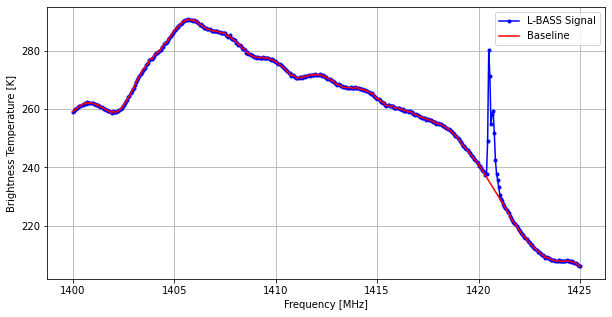

Empirical LSR correction found to be:  19.169416941694173 km / s km/s.


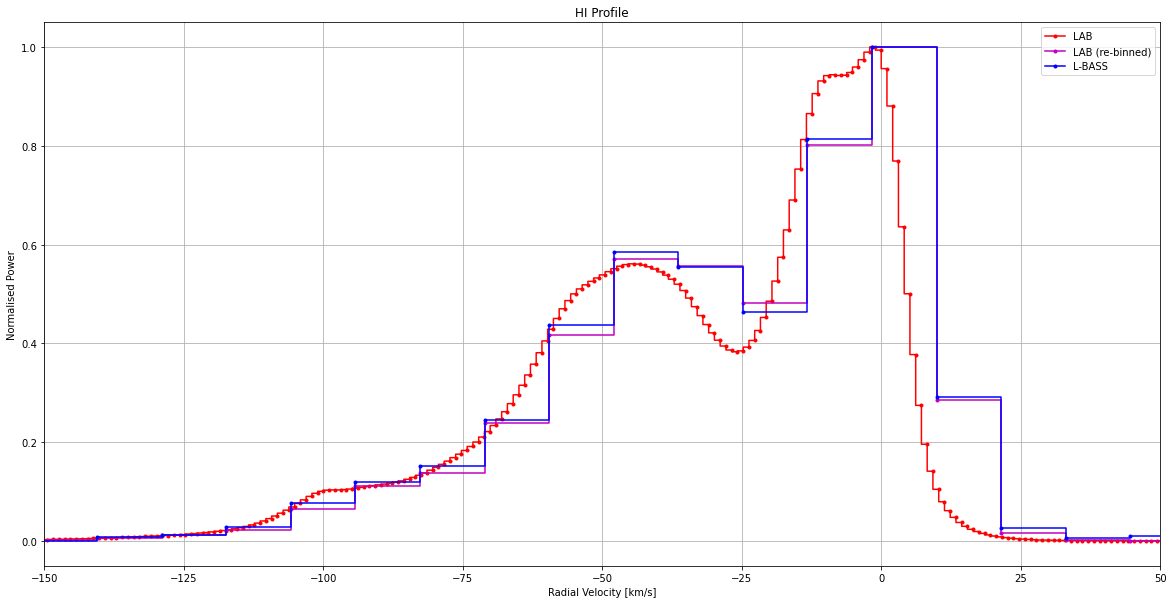

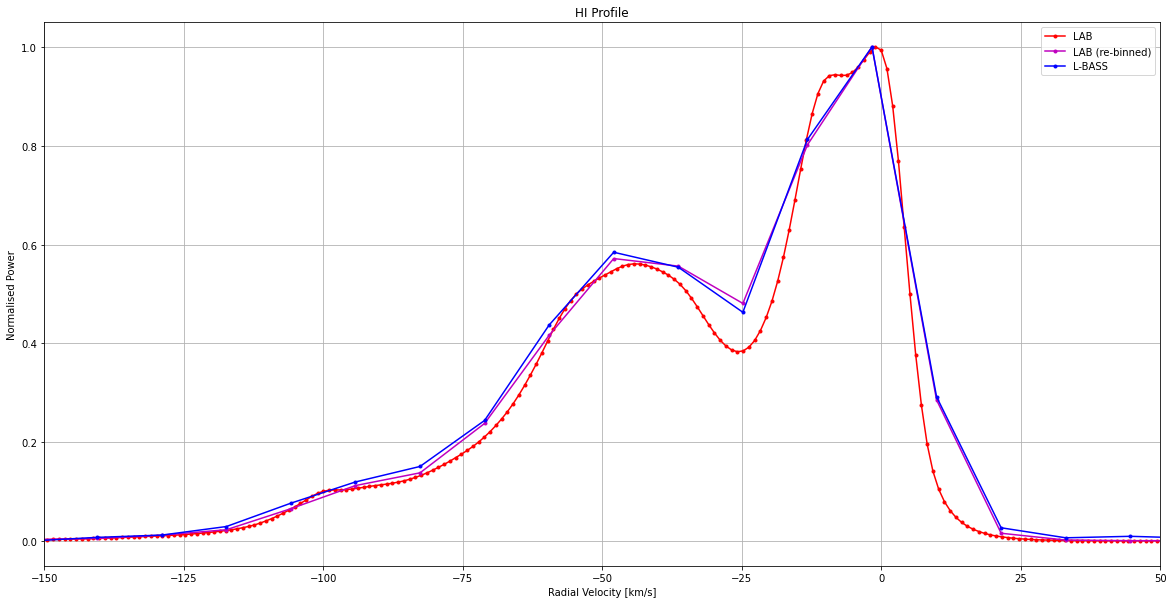

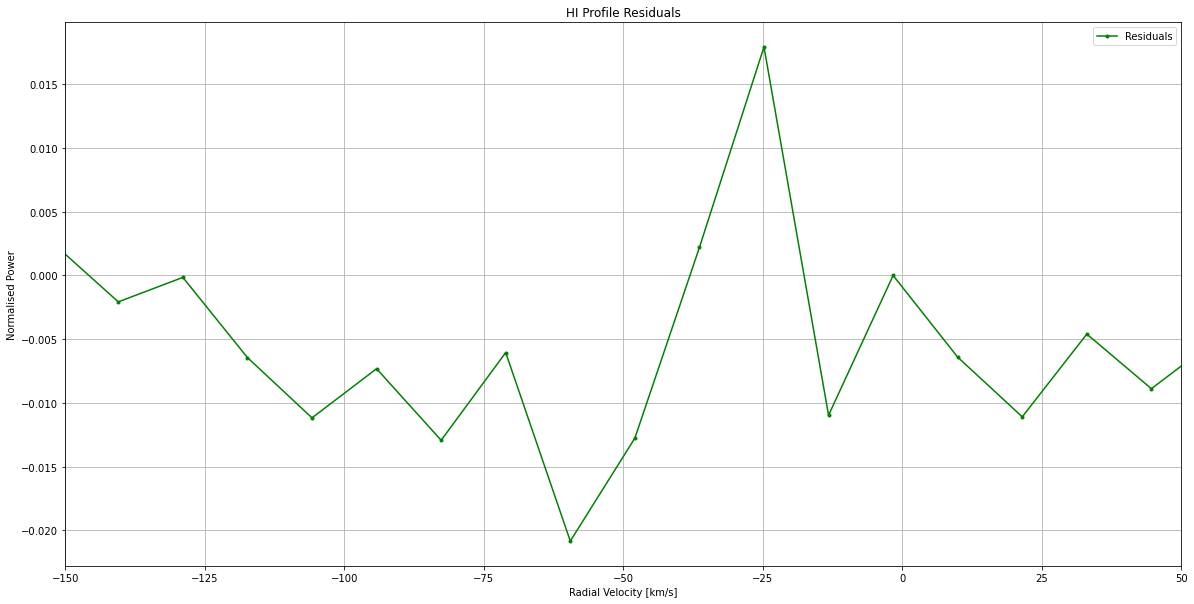

Area under LAB profile:  54.9
Area under L-BASS profile:  56.0
Difference as a % of L-BASS profile:  1.81 %


In [33]:
#example of running the profile_empirical_vel function on the 31/07/24 observation of S7
#takes ~3 mins to run - once you have the empirical LSR correction you can run the profile function with this value instead of waiting each time
profile_empirical_vel(s7_transit, 20, s7_lab, 480, 501)